<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/ppo_tsla_training_vs_buy_and_hold_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip uninstall -y protobuf tensorflow gym keras torch torchvision torchaudio || true
!pip install protobuf==3.20.3 tensorflow==2.18.0 stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib matplotlib pandas numpy scipy scikit-learn imblearn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.9.1
Uninstalling keras-3.9.1:
  Successfully uninstalled keras-3.9.1
Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached keras-3.9.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached to

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl (7.3 MB)
Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (3.4 MB)
ERROR: Operation cancelled by user
^C


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 606  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 4096 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 521           |
|    iterations           | 2             |
|    time_elapsed         | 15            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00018072406 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -0.286        |
|    learning_rate        | 5e-05         |
|    loss                 | 0.222         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000442     |
|    value_loss           | 0.751         |
------------------------

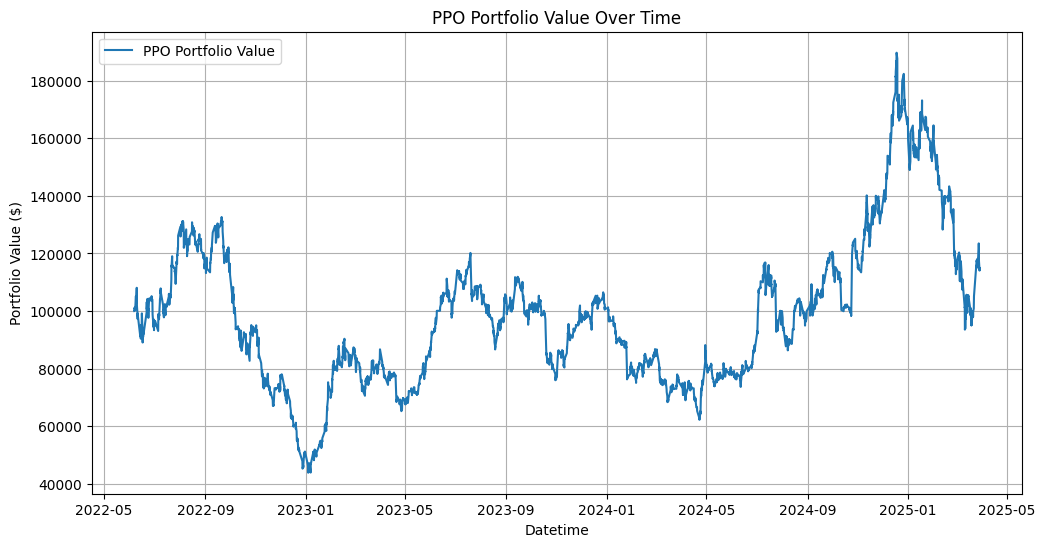

📁 PPO Portfolio results saved to: TSLA_ppo_v2_2025-03-31.json
📄 Trade log saved to CSV: TSLA_ppo_v2_2025-03-31.csv


In [10]:
# ================================
# ✅ Set Correct CUDA Paths
# ================================
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'

# ================================
# ✅ Import Required Libraries
# ================================
import pandas as pd
import numpy as np
import yfinance as yf
import gymnasium as gym
import gym_anytrading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.spaces import Discrete
import matplotlib.pyplot as plt
from datetime import datetime
import json
import time
import torch
import gc

# ================================
# ✅ Download and Clean Stock Data
# ================================
def clean_stock_data(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.rename(columns=lambda x: x.capitalize(), inplace=True)
    df.rename(columns={'Adj Close': 'Close'}, inplace=True)

    required_columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df[[col for col in required_columns if col in df.columns]]

    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df.dropna(subset=['Datetime', 'Close'], inplace=True)
    df.sort_values(by='Datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

# ✅ Load Stock Data (TSLA - 720 days, 1 hour interval)
df_live = yf.download("TSLA", period="720d", interval="1h")
df_live.reset_index(inplace=True)
df = clean_stock_data(df_live)

# ================================
# ✅ Feature Engineering (Technical Indicators)
# ================================
def compute_technical_indicators(df):
    df['ATR'] = (df['High'] - df['Low']).rolling(window=14).mean()
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    macd_fast = df['Close'].ewm(span=12).mean()
    macd_slow = df['Close'].ewm(span=26).mean()
    df['MACD_Line'] = macd_fast - macd_slow
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Volume_Avg'] = df['Volume'].rolling(window=20).mean()
    df['ADX'] = abs(df['High'] - df['Low']).rolling(window=14).mean()

    df.dropna(inplace=True)
    return df

df = compute_technical_indicators(df)

# ================================
# ✅ Custom Continuous Trading Environment for PPO
# ================================
class ContinuousTradingEnv(gym_anytrading.envs.StocksEnv):
    def __init__(self, df, frame_bound, window_size):
        super().__init__(df=df, frame_bound=frame_bound, window_size=window_size)

        # ✅ Update to Discrete Action Space for PPO
        self.action_space = Discrete(3)  # Actions: 0 - SELL, 1 - BUY, 2 - HOLD

    def step(self, action):
        # ✅ Map Discrete Action to BUY, SELL, HOLD
        if action == 0:
            discrete_action = 0  # SELL
        elif action == 1:
            discrete_action = 1  # BUY
        else:
            discrete_action = 2  # HOLD

        return super().step(discrete_action)

# ✅ Frame Bound Setup
frame_bound = (50, len(df))
window_size = 10

# ✅ Initialize Custom Trading Environment for PPO
env = ContinuousTradingEnv(df=df, frame_bound=frame_bound, window_size=window_size)
env = DummyVecEnv([lambda: env])

# ✅ Normalize the Environment (for Stable PPO)
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# ================================
# ✅ Define and Train PPO Model with Fine-Tuned Hyperparameters
# ================================
ppo_model = PPO(
    "MlpPolicy",
    env,
    learning_rate=5e-5,       # Lower learning rate for stability
    n_steps=4096,             # More steps per update
    batch_size=128,           # Larger batch size
    gamma=0.999,              # Higher gamma for long-term rewards
    gae_lambda=0.98,          # Better GAE estimation
    clip_range=0.1,           # Smaller clipping for gradual updates
    ent_coef=0.001,           # Less exploration as policy converges
    verbose=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# ✅ Free GPU Memory Before Training
gc.collect()
torch.cuda.empty_cache()

# ✅ Train PPO Model with Increased Timesteps
start_time = time.time()
ppo_model.learn(total_timesteps=1000000)  # Increased training timesteps
print(f"⏱️ Training Complete in {time.time() - start_time:.2f} seconds")

# ✅ Save PPO Model
ppo_model.save("/content/drive/My Drive/ppo_tsla_model_v2.zip")
print("✅ PPO Model saved successfully!")

# ================================
# ✅ Run PPO Trading Strategy
# ================================
obs = env.reset()
trade_log_ppo = []
buy_price = None

for i in range(len(df) - 50):
    action, _ = ppo_model.predict(obs)

    if action == 1 and buy_price is None:  # BUY
        trade_log_ppo.append("BUY")
        buy_price = df['Close'].iloc[i + 50]
    elif action == 0 and buy_price is not None:  # SELL
        trade_log_ppo.append("SELL")
        buy_price = None
    else:
        trade_log_ppo.append("HOLD")

# ✅ Handle Length Mismatch
df.loc[df.index[:50], "PPO_Trade_Signal"] = "HOLD"  # Pad initial 50 rows
df.loc[df.index[50:50 + len(trade_log_ppo)], "PPO_Trade_Signal"] = trade_log_ppo

# ================================
# ✅ Backtesting and Portfolio Calculation
# ================================
initial_balance = 100000
balance_ppo = initial_balance
position = 0
portfolio_values_ppo = []

for i, trade in enumerate(trade_log_ppo):
    price = df['Close'].iloc[i + 50]

    if trade == "BUY" and position == 0:
        position = balance_ppo / price
        balance_ppo = 0
    elif trade == "SELL" and position > 0:
        balance_ppo = position * price
        position = 0

    portfolio_values_ppo.append(balance_ppo if balance_ppo > 0 else position * price)

final_balance_ppo = portfolio_values_ppo[-1]
final_balance_hold = (initial_balance / df['Close'].iloc[50]) * df['Close'].iloc[-1]

# ================================
# ✅ Compute Performance Metrics for PPO
# ================================
results_df_ppo = pd.DataFrame({'Date': df['Datetime'].iloc[50:], 'Portfolio Value': portfolio_values_ppo})
results_df_ppo['Daily Return'] = results_df_ppo['Portfolio Value'].pct_change().fillna(0)

ppo_cumulative_return = ((results_df_ppo['Portfolio Value'].iloc[-1] / initial_balance) - 1) * 100
ppo_sharpe_ratio = (results_df_ppo['Daily Return'].mean() / results_df_ppo['Daily Return'].std()) * np.sqrt(252) if results_df_ppo['Daily Return'].std() != 0 else 0
ppo_max_drawdown = ((results_df_ppo['Portfolio Value'].cummax() - results_df_ppo['Portfolio Value']) / results_df_ppo['Portfolio Value'].cummax()).max() * 100

# ================================
# ✅ Final Results Summary
# ================================
print("\n🚀 FINAL RESULTS COMPARISON:")

print("🔹 **Reinforcement Learning (PPO)**")
print(f"📈 PPO Final Portfolio Value: ${final_balance_ppo:,.2f}")
print(f"📊 PPO Cumulative Return: {ppo_cumulative_return:.2f}%")
print(f"⚡ PPO Sharpe Ratio: {ppo_sharpe_ratio:.2f}")
print(f"📉 PPO Max Drawdown: {ppo_max_drawdown:.2f}%")
print(f"📊 PPO Trade Log (First 10): {trade_log_ppo[:10]} ...")

print("\n🔹 **Buy & Hold Baseline**")
print(f"📊 Buy & Hold Final Portfolio Value: ${final_balance_hold:,.2f}")

# ✅ Declare Winner Based on Portfolio Performance
winner = "PPO" if final_balance_ppo > final_balance_hold else "Buy & Hold"
print(f"\n🏆 **Best Strategy Based on Final Portfolio Value: {winner}!**")

# ================================
# ✅ Plot Portfolio Value Over Time
# ================================
plt.figure(figsize=(12, 6))
plt.plot(results_df_ppo['Date'], results_df_ppo['Portfolio Value'], label='PPO Portfolio Value')
plt.xlabel('Datetime')
plt.ylabel('Portfolio Value ($)')
plt.title('PPO Portfolio Value Over Time')
plt.legend()
plt.grid()
plt.show()

# ================================
# ✅ Save Results with Naming Convention
# ================================
def generate_filename(stock="TSLA", model="ppo", version="v2", ext="json", use_date=True):
    date_str = datetime.now().strftime("%Y-%m-%d") if use_date else ""
    return f"{stock}_{model}_{version}{'_' + date_str if use_date else ''}.{ext}"

def save_ppo_results(stock, final_balance_ppo, ppo_cumulative_return, ppo_sharpe_ratio, ppo_max_drawdown, trade_log_ppo, version="v2"):
    # ✅ Save to JSON
    results_path_json = generate_filename(stock, "ppo", version, "json")
    with open(results_path_json, "w") as f:
        json.dump({
            "model_name": "PPO",
            "final_value": final_balance_ppo,
            "cumulative_return": ppo_cumulative_return,
            "sharpe_ratio": ppo_sharpe_ratio,
            "max_drawdown": ppo_max_drawdown,
            "trade_log": trade_log_ppo[:10]  # Save only first 10 trades for brevity
        }, f, indent=2)

    # ✅ Save Trade Log to CSV
    results_path_csv = generate_filename(stock, "ppo", version, "csv")
    pd.DataFrame(trade_log_ppo, columns=["Trade Signal"]).to_csv(results_path_csv, index=False)

    print(f"📁 PPO Portfolio results saved to: {results_path_json}")
    print(f"📄 Trade log saved to CSV: {results_path_csv}")

# ✅ Save PPO Results
save_ppo_results(
    stock="TSLA",
    final_balance_ppo=final_balance_ppo,
    ppo_cumulative_return=ppo_cumulative_return,
    ppo_sharpe_ratio=ppo_sharpe_ratio,
    ppo_max_drawdown=ppo_max_drawdown,
    trade_log_ppo=trade_log_ppo
)
